In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import yaml

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from scipy import stats

import sys
import os

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

data_path = config['train']['data_path']

In [2]:
config

{'parcing': {'pred_days': 0.15,
  'URL': 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To='},
 'preprocessing': {'pred_days': 0.15,
  'random_sate': 42,
  'drop_trash': None,
  'train_path': '../data/df_train.csv',
  'test_path': '../data/df_test.csv',
  'df_path': '../data/df.csv'},
 'train': {'random_sate': 42,
  'pred_days_forecast': 180,
  'backend_path': '../backend/src/data',
  'data_path': '../data',
  'model_path': '../models',
  'study_path': '../models',
  'metrics_path': '../report/metrics.json',
  'params_path': '../report',
  'N_TRIALS': 1000,
  'TIMEOUT': 1200},
 'evaluate': {'predict_path': '../data/check/test.csv'},
 'frontend': {'main_image': '../data/frontend/main_image.png'},
 'endpoints': {'parcer': 'http://fatsapi:8000/parcer',
  'train': 'http://fastapi:8000/train',
  'prediction_test': 'http://fastapi:8000/prediction_test',
  'prediction_future': 'http://fastapi:8000/prediction_future'}}

## Описание работы
Проект использует данные по ключевой ставке Банка России для прогнозирования ее значений в будущем с помощью модели Prophet. Основные шаги проекта:
- Сбор исторических данных по ключевой ставке ЦБ РФ с официального сайта.
- Предобработка данных: очистка, заполнение пропусков, преобразование в формат для модели.
- Разделение данных на обучающую и тестовую выборки.
- Обучение модели Prophet на обучающей выборке. Prophet использует аддитивную модель с трендом и сезонностью.
- Оценка качества модели на тестовой выборке по метрикам RMSE, MAE, MAPE.
- Использование лучшей модели для прогнозирования ключевой ставки на заданный период в будущем.
- Анализ полученных прогнозов, сравнение с фактическими данными и решениями ЦБ РФ по ставке
- Обучение модели Prophet на полной выборке и предсказание ставки на будущие периоды<br>

Target - предсказание курса ключевой ставки ЦБ РФ
-   date - дата
-   key_rate - значение ключевой ставки ЦБ РФ

# Parcing data

In [3]:
def get_dataset(config):
    """
    Парсит ключевую ставку с URL сайта ЦБ РФ и возвращает pandas DataFrame.

    Параметры:
    config (dict): Словарь конфигурации, содержащий URL для парсинга.

    Возвращает:
    pd.DataFrame: DataFrame, содержащий спарсенные данные ключевой ставки.
    """
    url = config['parcing']["URL"] + date.today().strftime('%d.%m.%Y')
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
    except requests.exceptions.Timeout:
        print("Ошибка таймаута: не удалось получить данные с URL")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Ошибка запроса: {e}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find_all("table")

    df = pd.read_html(str(table))[0]
    df.iloc[:, 1:] /= 100
    df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)
    df.columns = ['date', 'key_rate']

    return df

In [4]:
# Парсинг ключевой ставки в df
df = get_dataset(config)

C:\Users\myxa-\AppData\Local\Temp\ipykernel_19224\2239040573.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
C:\Users\myxa-\AppData\Local\Temp\ipykernel_19224\2239040573.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       18.0
1       18.0
2       18.0
3       18.0
4       18.0
        ... 
2744     5.5
2745     5.5
2746     5.5
2747     5.5
2748     5.5
Name: Ставка, Length: 2749, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:] /= 100


In [5]:
# Общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2749 entries, 0 to 2748
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2749 non-null   datetime64[ns]
 1   key_rate  2749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.1 KB


In [6]:
# Основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2749.000000
mean,9.035922
std,3.489367
min,4.250000
25%,7.000000
50%,7.750000
75%,11.000000
max,20.000000


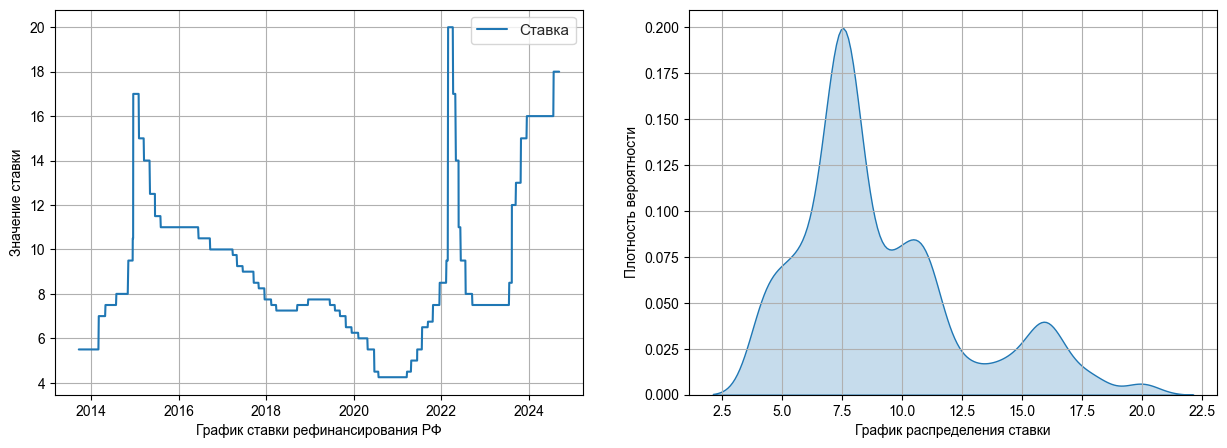

In [7]:
# Смотрим график курса ключевой ствки ЦБ РФ и график распределения
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=ax[0])
ax[0].set_xlabel('График ставки рефинансирования РФ')
ax[0].set_ylabel('Значение ставки')
ax[0].legend(loc='best')
ax[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=ax[1], fill=True)
ax[1].grid(True)
ax[1].set_xlabel('График распределения ставки')
ax[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [8]:
# Определение категориальных типов данных для дней недели и месяцев

def create_features(data: pd.DataFrame, col_datetime):
    """
    Создание новых признаков из столбца datetime в pandas DataFrame.

    Параметры:
    data (pd.DataFrame): Входной DataFrame
    col_datetime (str): Имя столбца datetime

    Возвращает:
    pd.DataFrame: DataFrame с добавленными новыми признаками
    """
    # Создание копии df
    data = data.copy()

    # Определение категориальных типов данных для дней недели и месяцев
    cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
    cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

    # Преобразование столбца datetime в формат datetime
    data[col_datetime] = pd.to_datetime(data[col_datetime])

    # Создание новых признаков
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)  # День недели
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)  # Месяц года
    data['year'] = data[col_datetime].dt.year  # Год
    data['quarter'] = data[col_datetime].dt.quarter  # Квартал года
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data[col_datetime].dt.day - 320) % 1300  # Пользовательский признак смещения даты
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})  # Сезон года

    return data

In [9]:
# Создание признаков
df_features = create_features(data=df, col_datetime='date')

In [10]:
def plot_features(data: pd.DataFrame):
    """
    Создает два графика для анализа ключевой ставки:
    1. Бары максимальных значений ставки по годам.
    2. Боксплот распределения ставки по дням недели и сезонам.

    Параметры:
    data (pd.DataFrame): DataFrame, содержащий данные о ключевой ставке, днях недели, сезоны.

    Возвращает:
    Два графика
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    year_group = pd.DataFrame(data.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

    sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
    ax[0].set_xlabel('Год')
    ax[0].set_ylabel('Значение ставки')

    sns.boxplot(data=data, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
    ax[1].set_xlabel('День недели')
    ax[1].set_ylabel('Значение ставки')

    return plt.show()

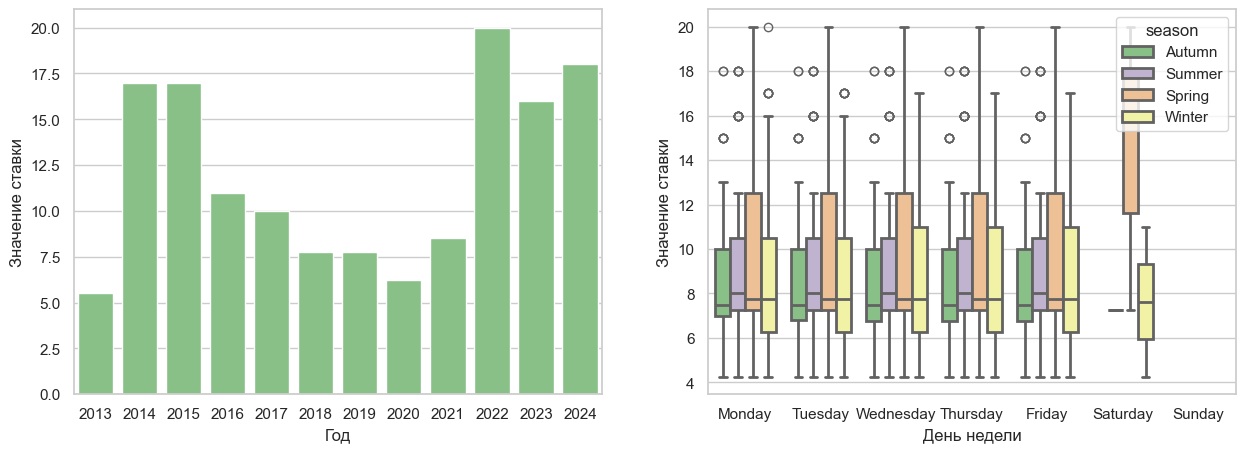

In [11]:
plot_features(df_features)

## Дропаем редкие субботние ставки

In [12]:
# Дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

Смотрим график после дропа суббот

In [13]:
# Создаем df с признаками после дропа суббот
df_features = create_features(data=df, col_datetime='date')

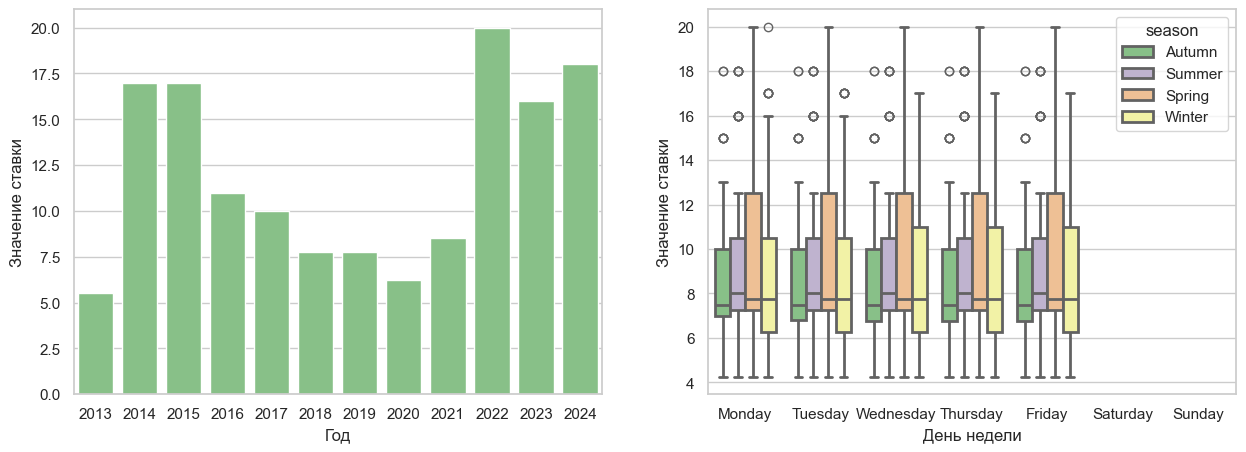

In [14]:
# Смотрим графики для анализа после дропа суббот
plot_features(df_features)

## Поиск и удаление статистических выбросов

## Определение выбросов при помощи IQR

In [15]:
def interpolate_missing_values(df: pd.DataFrame, column_name):
    """
    Фильтрация выбросов и интерполяция пропущенных значений в указанном столбце.

    Параметры:
    - df (pd.DataFrame): входные данные
    - column_name (str): имя столбца для обработки

    Возвращает:
    - df_filtered (pd.DataFrame): Интерполированные данные
    """
    # Определение последней даты, для заполнения графика интерполяцией
    last_date = df['date'].max()

    # Настройка фильтрации данных до последней даты
    mask = df['date'] < last_date

    # Вычисление межквартильного размаха (IQR)
    q1, q3 = df.loc[mask, column_name].quantile([0.25, 0.75])
    iqr = q3 - q1

    # Определение границ для выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Замена выбросов на NaN
    df_filtered = df.copy()
    df_filtered.loc[(df_filtered[column_name] < lower_bound) & mask, column_name] = np.nan
    df_filtered.loc[(df_filtered[column_name] > upper_bound) & mask, column_name] = np.nan

    # Интерполируем пропущенные значения
    df_filtered[column_name] = df_filtered[column_name].interpolate(method='nearest', order=3)

    return df_filtered

In [16]:
df_filtered = interpolate_missing_values(df, 'key_rate')

In [17]:
def plot_interpolate(df: pd.DataFrame, df_filtered: pd.DataFrame):
    """
    Визуализация оригинальных и отфильтрованных данных ключевой ставки.

    Параметры:
    df (pd.DataFrame): Оригинальные данные ключевой ставки.
    df_filtered (pd.DataFrame): Отфильтрованные данные ключевой ставки.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.set_theme(style="whitegrid", palette="Accent")

    sns.lineplot(x='date', y='key_rate', data=df, label='Оригинальные данные', ax=ax)
    sns.lineplot(x='date', y='key_rate', data=df_filtered, label='Отфильтрованные данные', ax=ax)

    ax.set_xlabel('Год')
    ax.set_ylabel('Значение ставки')
    ax.set_title('Визуализация после вычисления выбросов')
    ax.legend(loc='best')
    ax.grid(True)

    return plt.show()

In [18]:
# Создаем df с признаками после замены статистических выбросов интерполяцией
df_features = create_features(data=df_filtered, col_datetime='date')

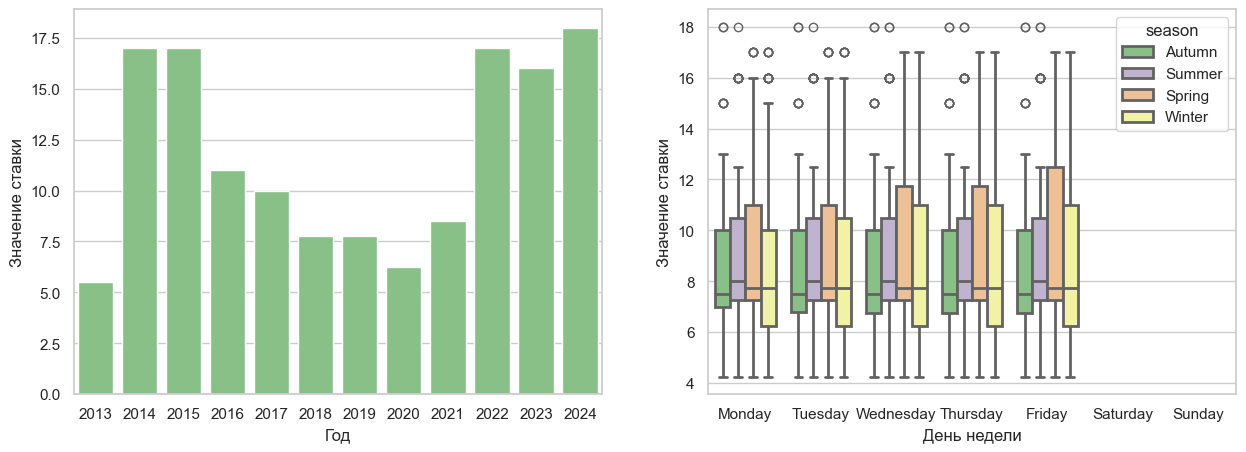

In [19]:
# Смотрим графики после замены статистических выбросов интерполяцией
plot_features(df_features)

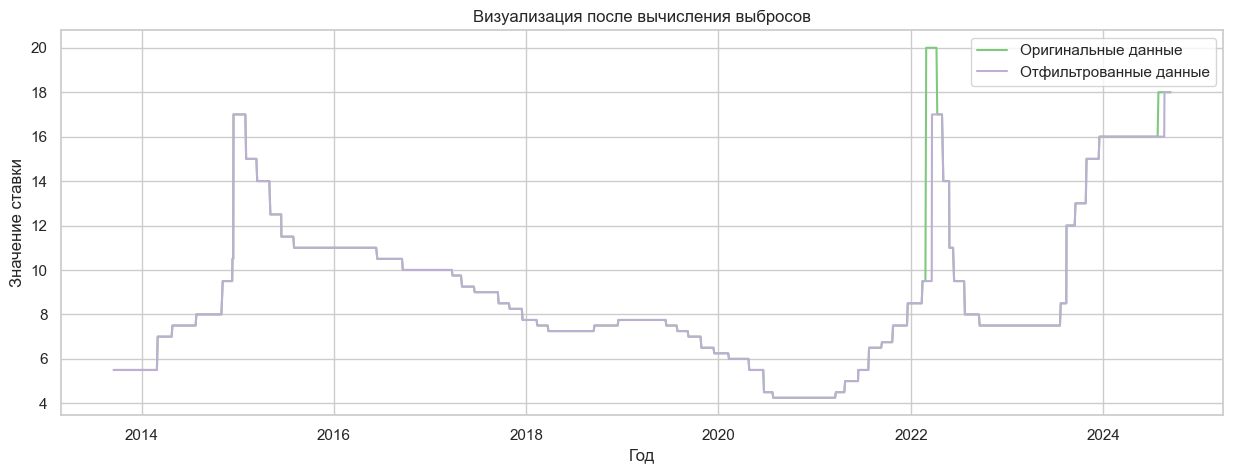

In [20]:
# Смотрим график после замены выбросов интерполяцией пропущенных значений
plot_interpolate(df, df_filtered)

In [21]:
def prepare_data_for_prophet(df: pd.DataFrame, **kwargs):
    """
    Подготовка интеполируемых данных для Prophet путем переименования столбцов и сортировке по дате.

    Параметры:
    df (pd.DataFrame): Интеполируемые данные

    Возвращает:
    pd.DataFrame: Подготовленные данные для Prophet
    """

    # Переименовываем столбцы для Prophet
    df.columns = ['ds', 'y']

    # Сортируем данные по дате в порядке возрастания
    df = df.sort_values('ds')
    df = df.reset_index(drop=True)

    # Сохранение DataFrame df в файл data/df.csv
    df_path = config['preprocessing']['df_path']
    df.to_csv(df_path, index=False)
    
    return df

In [22]:
df = prepare_data_for_prophet(df_filtered)

In [23]:
# # сохранение интерполируемых данных в df
# df = df_filtered

# # Перенаименование названия колонок для prophet
# df.columns = ['ds', 'y']

# # Период, который надо отрезать и предсказать (проверка модели)
# pred_days = int(df.shape[0]*config['parcing']['pred_days'])


In [24]:
# # Сортируем данные по возрастанию для корректного отображения разделения графика по возрастанию даты
# df = df.sort_values('ds')
# df = df.reset_index(drop=True)

In [25]:
def split_dataset(df: pd.DataFrame, config):
    """
    Разделение данных на обучающую и тестовую выборки и сохранение их в файлы.

    Параметры:
    df (pd.DataFrame): Входные данные
    config (словарь): Словарь, содержащий параметры конфигурации
    data_path (строка): Путь к директории для сохранения файлов

    Возвращает:
    df_train (pd.DataFrame): Обучающая выборка
    df_test (pd.DataFrame): Тестовая выборка
    """
    pred_days = int(df.shape[0]*config['parcing']['pred_days'])
    df_train = df[:-pred_days]
    df_test = df[-pred_days:]
    
    # Сохранение DataFrame df_train в файл data/df_train.csv
    train_path = config['preprocessing']['train_path']
    df_train.to_csv(train_path, index=False)
    
    # Сохранение DataFrame df_test в файл data/df_test.csv
    test_path = config['preprocessing']['test_path']
    df_test.to_csv(test_path, index=False)

    return df_train, df_test

In [26]:
df_train, df_test = split_dataset(df, config)

In [27]:
# # Период, который надо отрезать и предсказать (проверка модели)
# pred_days = int(df.shape[0]*config['parcing']['pred_days'])

# # Разделение данных на train, test
# df_train = df[:-pred_days]
# df_test = df[-pred_days:]

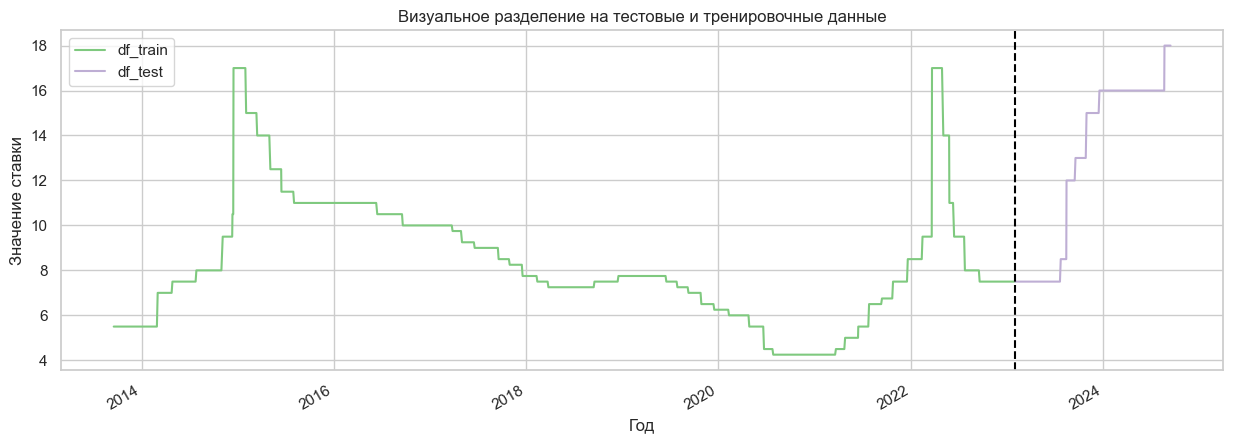

In [28]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()